In [1]:
import os
os.chdir('../')  # Moving up one directory to the root
!python --version
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
print("done")

Python 3.12.4
done


In [2]:
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from main import SentimentAnalyzer
from models.sentiment_model import EnhancedDistilBertForSentiment, ModelTrainer
from config.model_config import ModelConfig
import matplotlib.pyplot as plt
import seaborn as sns
print("done")

done


In [3]:
# Initialize analyzer
analyzer = SentimentAnalyzer()

# Process and show preprocessing examples
train_texts, val_texts, train_labels, val_labels = analyzer.process_data()
print("done")


Preprocessing Examples:

Original: Great service and amazing food!
Processed: Great service and amazing food!

Original: Terrible experience, would not recommend.
Processed: Terrible experience, would not_NEG recommend.

Original: The food was okay, but the service could be better.
Processed: The food was okay, but the service could be better.

Original: Yeah right, like that's going to work...
Processed: Yeah right, like that is going to work ELLIPSIS  _SARC_yeah right

Original: Thanks a lot... now everything is broken 🙄
Processed: Thanks a lot ELLIPSIS  now everything is broken 🙄 _SARC_thanks a lot (contextual)

Original: Obviously this is the best restaurant ever...
Processed: Obviously this is the best restaurant ever ELLIPSIS 
done


In [4]:
# Create the analyzer instance first
analyzer = SentimentAnalyzer()

# Then initialize the model
analyzer.initialize_model()
analyzer.initialize_model()

# Show model configuration
print("Model Configuration:")
print(f"BERT Model: {ModelConfig.BERT_MODEL}")
print(f"Learning Rate: {ModelConfig.LEARNING_RATE}")
print(f"Batch Size: {ModelConfig.BATCH_SIZE}")
print(f"Max Length: {ModelConfig.MAX_LENGTH}")
print("done")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.

Model Configuration:
BERT Model: distilbert-base-uncased
Learning Rate: 1e-05
Batch Size: 32
Max Length: 200
done


In [5]:
# Create a dummy input to build the model
dummy_input = analyzer.tokenizer(
    "This is a dummy text", 
    return_tensors='tf',
    padding=True,
    truncation=True,
    max_length=ModelConfig.MAX_LENGTH
)

# Build the model by passing dummy input
_ = analyzer.model(dummy_input)
analyzer.model.summary()
print("done")

Model: "enhanced_distil_bert_for_sentiment_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model_1 (TF  multiple                  66362880  
 DistilBertModel)                                                
                                                                 
 bidirectional_1 (Bidirecti  multiple                  1154400   
 onal)                                                           
                                                                 
 dense_5 (Dense)             multiple                  30048     
                                                                 
 dense_6 (Dense)             multiple                  30048     
                                                                 
 dense_7 (Dense)             multiple                  30048     
                                                                 
 dense_8 (Dense)             m

Epoch 1/5
169/169 [==============================] - 1147s 7s/step - loss: 1.1949 - negation_loss: 0.2323 - polarity_loss: 0.1670 - sarcasm_loss: 0.2230 - sentiment_loss: 0.9171 - negation_accuracy: 0.9798 - polarity_mae: 0.3263 - sarcasm_accuracy: 0.9930 - sentiment_accuracy: 0.5437 - val_loss: 0.8098 - val_negation_loss: 0.1035 - val_polarity_loss: 0.0492 - val_sarcasm_loss: 0.0914 - val_sentiment_loss: 0.6976 - val_negation_accuracy: 1.0000 - val_polarity_mae: 0.1902 - val_sarcasm_accuracy: 1.0000 - val_sentiment_accuracy: 0.6917 - lr: 9.8246e-06
Epoch 2/5
169/169 [==============================] - 1525s 9s/step - loss: 0.8354 - negation_loss: 0.0870 - polarity_loss: 0.2113 - sarcasm_loss: 0.0784 - sentiment_loss: 0.6893 - negation_accuracy: 1.0000 - polarity_mae: 0.3673 - sarcasm_accuracy: 1.0000 - sentiment_accuracy: 0.7072 - val_loss: 0.7228 - val_negation_loss: 0.0655 - val_polarity_loss: 0.0453 - val_sarcasm_loss: 0.0571 - val_sentiment_loss: 0.6480 - val_negation_accuracy: 1.0

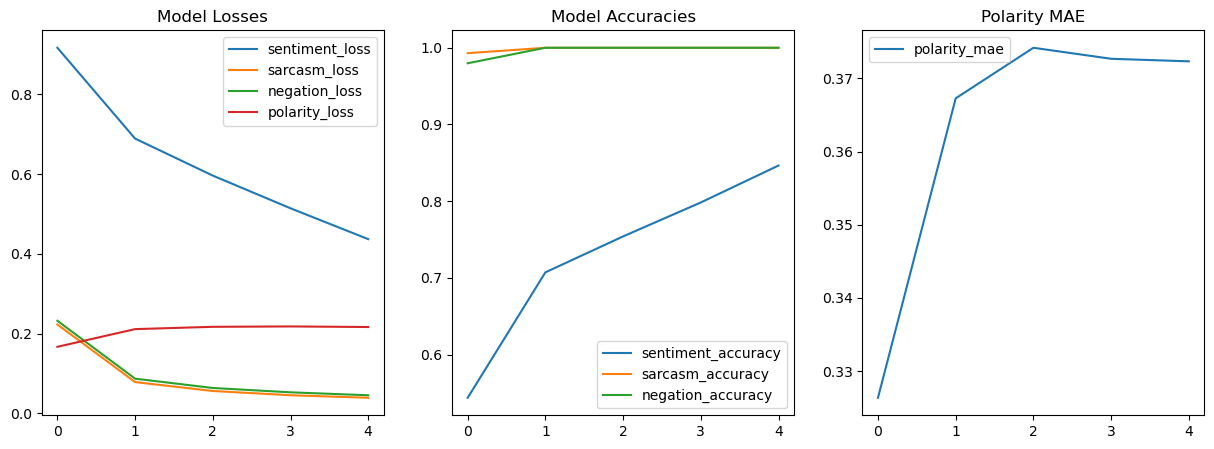

done


In [6]:
# Train model

history = analyzer.train()

# training visualization
plt.figure(figsize=(15, 5))
# Loss plots
plt.subplot(1, 3, 1)
for metric in ['sentiment_loss', 'sarcasm_loss', 'negation_loss', 'polarity_loss']:
    if metric in history.history:
        plt.plot(history.history[metric], label=metric)
plt.title('Model Losses')
plt.legend()

# Accuracy plots
plt.subplot(1, 3, 2)
for metric in ['sentiment_accuracy', 'sarcasm_accuracy', 'negation_accuracy']:
    if metric in history.history:
        plt.plot(history.history[metric], label=metric)
plt.title('Model Accuracies')
plt.legend()

# MAE for polarity
plt.subplot(1, 3, 3)
if 'polarity_mae' in history.history:
    plt.plot(history.history['polarity_mae'], label='polarity_mae')
plt.title('Polarity MAE')
plt.legend()
plt.show()
print("done")

In [7]:
test_cases = {
   'positive': [
       "The service was exceptional! The staff went above and beyond, the food was perfectly cooked, and the ambiance was wonderful. Everything from appetizers to dessert was a delight. Will definitely return!",
       "What an amazing dining experience! Every dish was beautifully presented, flavors were incredible, and the chef's special menu was innovative. Service was impeccable and attentive.",
       "First time here and absolutely loved it! The seafood pasta was fresh and flavorful, wine selection was excellent, and the outdoor seating area is gorgeous. Worth every penny!",
       "Best restaurant in the city! Incredible selection of dishes, outstanding cocktails, and the desserts are to die for. The atmosphere is perfect for both casual dining and special occasions.",
       "Phenomenal experience from start to finish! The steak was cooked to perfection, sides were creative and delicious, and the service was top-notch. Can't wait to come back!"
   ],
   'negative': [
       "Terrible experience. Food was cold, service was slow, and prices were ridiculous for what we got. The waiter was rude and unattentive. Definitely won't be coming back to this place.",
       "Disappointing dinner. Everything was bland, overcooked, and overpriced. Waited 45 minutes for our main course and the restaurant wasn't even busy. Save your money and go elsewhere.",
       "Worst dining experience ever! The food was inedible, the place was dirty, and we found a hair in our salad. Management didn't even care when we complained. Avoid at all costs!",
       "Complete waste of money. The portions were tiny, food was mediocre at best, and the service was awful. The place was too noisy and the tables were uncomfortably close together.",
       "Extremely disappointing. Food arrived cold, drinks were watered down, and the place was unclean. Staff seemed untrained and disinterested. Definitely not worth the high prices."
   ],
   'neutral': [
       "The food was okay, nothing special. Service was standard, and prices were what you'd expect. The place was clean but basic. Might return if in the area, but wouldn't go out of my way.",
       "Average experience overall. Some dishes were good, others were mediocre. Service was acceptable but not memorable. The atmosphere was typical for this type of restaurant.",
       "Had dinner here last night. Food came on time, taste was decent. Prices are standard for the area. The place is what you'd expect from a casual dining restaurant.",
       "Regular restaurant experience. The menu has typical options, service was neither good nor bad. Ambiance is basic. It's fine for a quick meal but don't expect anything extraordinary.",
       "Standard dining experience. Food was edible but not remarkable. Wait staff were polite but busy. Prices are average for what you get. It's an okay option if you're in the neighborhood."
   ],
   'sarcasm': [
       "Oh yeah, waiting an hour for cold food is EXACTLY what I wanted for my birthday. The rude service really made the experience special. Just perfect! 🙄",
       "Wow, thanks SO MUCH for the amazing experience of watching other tables get served while we waited. The cold food was definitely worth the two-hour wait! 😒",
       "Sure, charging $50 for microwaved pasta is totally reasonable! And the waiter's attitude? Cherry on top! Obviously the best restaurant ever... 🙄",
       "Yeah right, this place is definitely deserving of its 'premium' status. Nothing says luxury like paper napkins and plastic cups. Simply magnificent... 😏",
       "Just what I needed - overpriced, undercooked food with a side of attitude! The sticky tables really added to the 'authentic' experience. Thanks a lot! 🙄"
   ],
   'negation': [
       "The food was not fresh at all. Service wasn't good either. The ambiance didn't match the prices, and the manager wouldn't address our concerns.",
       "Cannot recommend this place. The menu isn't extensive, prices aren't reasonable, and the staff didn't seem to care about customer service at all.",
       "The restaurant didn't meet our expectations. Food wasn't hot when served, flavors weren't balanced, and the waiter never checked on our table.",
       "This place is not worth visiting. The food wasn't properly cooked, service wasn't professional, and the atmosphere wasn't pleasant at all.",
       "The chef couldn't cook properly. The staff didn't know the menu, and the manager wouldn't accept any feedback. Never returning here."
   ],
   'multipolar': [
       "Great appetizers but terrible main courses. The service was excellent, yet the prices were outrageous. Beautiful decor but unbearably noisy.",
       "The food was delicious but the service was awful. Love the atmosphere, however the cleanliness needs work. Amazing cocktails but terrible wine selection.",
       "Fantastic starters but disappointing entrees. The staff was friendly but extremely slow. Beautiful venue but uncomfortable seating arrangements.",
       "Excellent food quality but tiny portions. The bartender was amazing, yet the servers were rude. Love the concept but poor execution.",
       "Perfect location but horrible parking. The food was tasty but overpriced. Friendly host but inattentive waiters. Mixed feelings about this place."
   ],
   'long_reviews': [
       "Had a truly memorable experience at this establishment last weekend. The atmosphere immediately draws you in with its perfect blend of modern and classic decor. Started with their signature appetizers - the calamari was perfectly crispy and the truffle fries were addictive. Main courses were even better; the sea bass was cooked to perfection and practically melted in the mouth. Wine pairing suggestions were spot-on. Service was attentive without being intrusive. The dessert menu was innovative - tried their deconstructed cheesecake which was a delightful surprise. Pricing was on the higher side but justified by the quality. Will definitely return!",
       "After months of trying to get a reservation, our experience was unfortunately disappointing. While the ambiance was elegant with stunning city views, everything else fell short. Service was painfully slow and disorganized - waited 45 minutes between appetizers and main course. The food arrived lukewarm and wasn't worth the premium pricing. The wagyu steak was overcooked despite requesting medium-rare, and the seafood platter didn't taste fresh. When we raised these issues, the manager seemed indifferent. The cocktails were the only saving grace, but not enough to warrant a second visit. Save your money and try somewhere else.",
       "The restaurant offers a standard dining experience with some hits and misses. Decor is contemporary but could use updating. The menu features typical Italian dishes - some executed well, others needing improvement. Service was adequate but not exceptional, and prices align with similar establishments in the area. The pasta dishes were cooked properly, though sauces lacked depth. Wine list is decent but not extensive. Seating is comfortable, noise level manageable. Parking can be challenging during peak hours. It's a safe choice for casual dining but doesn't stand out in any particular way.",
       "Oh, what a 'delightful' evening! 🙄 Absolutely LOVED waiting 45 minutes past our reservation time, especially appreciated being squeezed into a tiny table right by the kitchen door. The waiter's complete lack of knowledge about the menu was simply CHARMING! And how thoughtful of them to serve us cold food at premium prices - such a unique dining concept! The manager's defensive attitude when we complained was the cherry on top of this 'exceptional' experience. But hey, at least the water glasses were full... when we could find someone to fill them. Just perfect for our anniversary celebration!",
       "This restaurant perfectly embodies both excellence and disappointment. The appetizers were absolutely stunning - perfectly seasoned and beautifully presented. However, the main courses were a complete letdown with overcooked proteins and bland sauces. The sommelier was incredibly knowledgeable and helpful, but our server was inattentive and seemed disinterested. The venue itself is gorgeous with amazing waterfront views, yet the tables are uncomfortably close together. The dessert menu looked promising but the execution was inconsistent. Mixed feelings about recommending this place despite its potential."
   ]
}

print("\nComprehensive Sentiment Analysis:")
for category, cases in test_cases.items():
    print(f"\n{category.upper()} CASES:")
    print("-" * 80)
    
    for text in cases:
        results = analyzer.predict(text)
        print(f"\nText: {text}")
        print(f"Sentiment: {max(results['sentiment'].items(), key=lambda x: x[1])[0]}")
        print(f"Sentiment Distribution: neg={results['sentiment']['negative']:.2f}, "
              f"neu={results['sentiment']['neutral']:.2f}, "
              f"pos={results['sentiment']['positive']:.2f}")
        print(f"Sarcasm: {results['sarcasm']['detected']}")
        print(f"Negation: {results['negation']['detected']}")
        print(f"Multipolarity Score: {results['multipolarity']['score']:.2f}")
        print(f"Is Multipolar: {results['multipolarity']['is_multipolar']}")
        print("-" * 50)

print("done")


Comprehensive Sentiment Analysis:

POSITIVE CASES:
--------------------------------------------------------------------------------

Text: The service was exceptional! The staff went above and beyond, the food was perfectly cooked, and the ambiance was wonderful. Everything from appetizers to dessert was a delight. Will definitely return!
Sentiment: positive
Sentiment Distribution: neg=0.22, neu=0.22, pos=0.56
Sarcasm: True
Negation: True
Multipolarity Score: 0.53
Is Multipolar: True
--------------------------------------------------

Text: What an amazing dining experience! Every dish was beautifully presented, flavors were incredible, and the chef's special menu was innovative. Service was impeccable and attentive.
Sentiment: positive
Sentiment Distribution: neg=0.22, neu=0.23, pos=0.55
Sarcasm: True
Negation: True
Multipolarity Score: 0.52
Is Multipolar: True
--------------------------------------------------

Text: First time here and absolutely loved it! The seafood pasta was fre

In [16]:
import tensorflow as tf
def save_enhanced_model(model, epoch, history, model_dir='./saved_models/'):
    """
    Save the Enhanced DistilBERT model with HuggingFace components
    """
    os.makedirs(model_dir, exist_ok=True)
    
    # 1. Save model weights
    weights_path = f"{model_dir}enhanced_distilbert_epoch{epoch}_weights"
    model.save_weights(weights_path)
    
    # 2. Save the DistilBERT configuration
    distilbert_config = model.distilbert.config
    distilbert_config_path = f"{model_dir}distilbert_config_epoch{epoch}.json"
    distilbert_config.to_json_file(distilbert_config_path)
    
    # 3. Save custom model architecture parameters
    model_params = {
        'lstm_units': ModelConfig.LSTM_UNITS,
        'attention_dim': ModelConfig.ATTENTION_DIM,
        'fusion_layers': ModelConfig.FUSION_LAYERS,
        'dropout_rates': ModelConfig.DROPOUT_RATES,
        'num_classes': ModelConfig.NUM_CLASSES
    }
    
    # Convert history to regular Python types
    converted_history = {}
    for key, value in history.history.items():
        converted_history[key] = [float(v) for v in value]
    
    # 4. Save training history and configuration
    save_info = {
        'epoch': int(epoch),
        'history': converted_history,
        'model_parameters': model_params,
        'weights_path': weights_path
    }
    
    # Save as JSON file
    with open(f"{model_dir}model_info_epoch{epoch}.json", 'w') as f:
        json.dump(save_info, f)
        
    print(f"Model weights and configuration saved for epoch {epoch}")

In [17]:
import json
import os
save_enhanced_model(
    model=analyzer.model,
    epoch=5,
    history=history,
    model_dir='./saved_models/'
)

Model weights and configuration saved for epoch 5


In [15]:
# Check current working directory
import os
print("Current working directory:", os.getcwd())

# List contents of current directory
print("\nContents of current directory:", os.listdir())

# Check if saved_models exists in current directory
if 'saved_models' in os.listdir():
    print("\nContents of saved_models:", os.listdir('saved_models'))
else:
    print("\nsaved_models not found in current directory")

Current working directory: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/notebooks

Contents of current directory: ['01_data_exploration.ipynb', '02_model_training.ipynb', '.ipynb_checkpoints']

saved_models not found in current directory


In [2]:
import sys
import os

# Add project root to Python path
project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Now try the imports with correct path
import json
import tensorflow as tf
from models.sentiment_model import EnhancedDistilBertForSentiment
from config.model_config import ModelConfig

def load_enhanced_model(epoch, model_dir):
    """
    Load the saved Enhanced DistilBERT model
    """
    model_dir = os.path.join(project_root, 'saved_models')
    print(f"Loading from directory: {model_dir}")
    
    # 1. Load model info
    with open(os.path.join(model_dir, f"model_info_epoch{epoch}.json"), 'r') as f:
        model_info = json.load(f)
    
    # 2. Initialize new model
    model = EnhancedDistilBertForSentiment()
    
    # 3. Build the model with dummy data
    dummy_input = {
        'input_ids': tf.zeros((1, ModelConfig.MAX_LENGTH), dtype=tf.int32),
        'attention_mask': tf.zeros((1, ModelConfig.MAX_LENGTH), dtype=tf.int32)
    }
    _ = model(dummy_input)
    
    # 4. Load saved weights
    weights_path = os.path.join(model_dir, f"enhanced_distilbert_epoch{epoch}_weights")
    model.load_weights(weights_path)
    
    return model, model_info['history']

# Load the model
loaded_model, training_history = load_enhanced_model(
    epoch=5,
    model_dir='../saved_models'
)

2024-12-03 12:51:33.012450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading from directory: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Available metrics: ['loss', 'negation_loss', 'polarity_loss', 'sarcasm_loss', 'sentiment_loss', 'negation_accuracy', 'polarity_mae', 'sarcasm_accuracy', 'sentiment_accuracy', 'val_loss', 'val_negation_loss', 'val_polarity_loss', 'val_sarcasm_loss', 'val_sentiment_loss', 'val_negation_accuracy', 'val_polarity_mae', 'val_sarcasm_accuracy', 'val_sentiment_accuracy', 'lr']

Final values:
loss: 0.5443
negation_loss: 0.0454
polarity_loss: 0.2166
sarcasm_loss: 0.0391
sentiment_loss: 0.4371
negation_accuracy: 1.0000
polarity_mae: 0.3723
sarcasm_accuracy: 1.0000
sentiment_accuracy: 0.8465
val_loss: 0.7097
val_negation_loss: 0.0377
val_polarity_loss: 0.0398
val_sarcasm_loss: 0.0312
val_sentiment_loss: 0.6633
val_negation_accuracy: 1.0000
val_polarity_mae: 0.1623
val_sarcasm_accuracy: 1.0000
val_sentiment_accuracy: 0.7317
lr: 0.0000


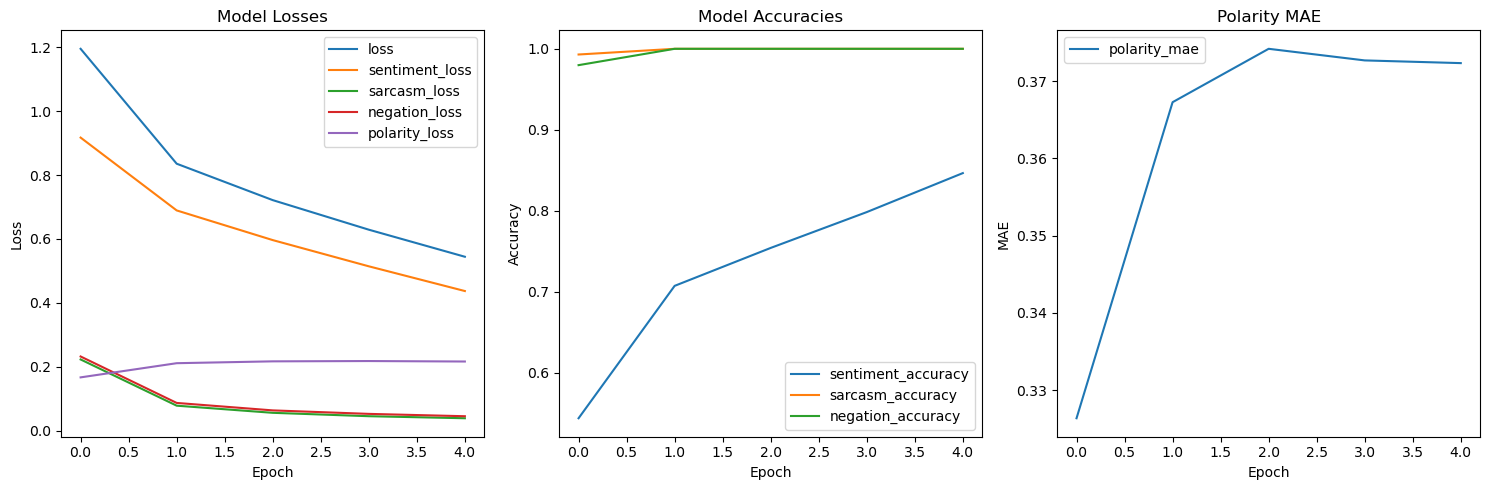

In [4]:
# Print available metrics
print("Available metrics:", list(training_history.keys()))

# Print final values for each metric
print("\nFinal values:")
for metric, values in training_history.items():
    print(f"{metric}: {values[-1]:.4f}")

# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Loss plots
plt.subplot(1, 3, 1)
for metric in ['loss', 'sentiment_loss', 'sarcasm_loss', 'negation_loss', 'polarity_loss']:
    if metric in training_history:
        plt.plot(training_history[metric], label=metric)
plt.title('Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plots
plt.subplot(1, 3, 2)
for metric in ['sentiment_accuracy', 'sarcasm_accuracy', 'negation_accuracy']:
    if metric in training_history:
        plt.plot(training_history[metric], label=metric)
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# MAE for polarity
plt.subplot(1, 3, 3)
if 'polarity_mae' in training_history:
    plt.plot(training_history['polarity_mae'], label='polarity_mae')
plt.title('Polarity MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


TOTAL REVIEWS ANALYZED: 300
CORRECT PREDICTIONS: 241
INCORRECT PREDICTIONS: 59
ACCURACY: 0.803

DETAILED METRICS PER CLASS:

POSITIVE:
Precision: 0.782
Recall: 0.860
F1-score: 0.819
Support: 100.0

NEGATIVE:
Precision: 0.808
Recall: 0.840
F1-score: 0.824
Support: 100.0

NEUTRAL:
Precision: 0.826
Recall: 0.710
F1-score: 0.763
Support: 100.0

AGGREGATE SCORES:
Macro Avg Precision: 0.805
Macro Avg Recall: 0.803
Macro Avg F1-score: 0.802


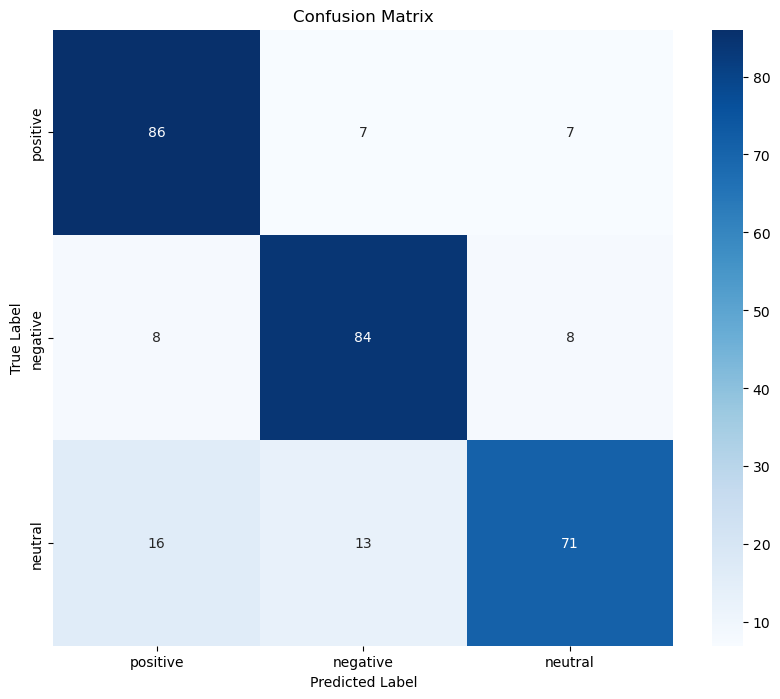


EXAMPLE REVIEWS WITH FEATURES:

Review 1 (354 characters):
Text: While some might complain about the price point, I found the overall appliance experience to be exceptional. The functionality is remarkable, and contrary to other reviews, the durability performs brilliantly. The attention to detail is evident in every aspect. Even the maintenance surpassed my expectations. A stellar example of quality and innovation.
True Sentiment: positive
Predicted Sentiment: positive
Features present:
- Sarcasm: False
- Negation: False
- Multipolarity: True
--------------------------------------------------------------------------------

Review 2 (338 characters):
Text: I really wanted to love this product, but unfortunately, it falls short in almost every aspect. Sure, the reliability might be excellent, but that doesn't make up for the terrible design. Despite what the marketing claims, the user experience is problematic, and the performance stability is even worse. Not worth the frustration or c

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import random

def generate_review_templates():
    """Generate templates for different sentiment categories with complex features."""
    templates = {
        'positive': [
            "Despite initial concerns about {aspect1}, I was absolutely blown away by this {item}. The {aspect2} exceeded all expectations, and even though I've tried many similar {items} before, this one stands out. The {aspect3} was {pos_adj1}, the {aspect4} was {pos_adj2}, and I particularly enjoyed the {feature}. {pos_conclusion}",
            
            "I have to admit, I was skeptical at first about the {item}, especially given my past experiences. However, after {duration} of use, I'm thoroughly impressed. Not only is the {aspect1} {pos_adj1}, but the {aspect2} is also {pos_adj2}. {pos_detail} The {aspect3} works flawlessly, and the {feature} is an added bonus. {pos_conclusion}",
            
            "While some might complain about the {neg_aspect}, I found the overall {item} experience to be exceptional. The {aspect1} is {pos_adj1}, and contrary to other reviews, the {aspect2} performs brilliantly. {pos_detail} Even the {aspect3} surpassed my expectations. {pos_conclusion}"
        ],
        
        'negative': [
            "I really wanted to love this {item}, but unfortunately, it falls short in almost every aspect. Sure, the {aspect1} might be {pos_adj1}, but that doesn't make up for the terrible {aspect2}. Despite what the marketing claims, the {aspect3} is {neg_adj1}, and the {aspect4} is even worse. {neg_conclusion}",
            
            "Don't waste your money on this {item}! While everyone raves about the {aspect1}, I found it to be completely {neg_adj1}. The {aspect2} stopped working after {duration}, the {aspect3} is {neg_adj2}, and customer service was no help at all. {neg_detail} Save yourself the trouble and look elsewhere. {neg_conclusion}",
            
            "Oh, how 'wonderful' it is to spend {price} on a {item} that barely functions! *sarcasm* The {aspect1} is 'amazing' if you enjoy {neg_detail}. And don't even get me started on the {aspect2} - it's 'perfectly' {neg_adj1}. {neg_conclusion}"
        ],
        
        'neutral': [
            "The {item} has both pros and cons worth considering. While the {aspect1} is {pos_adj1} and the {aspect2} is decent, the {aspect3} leaves room for improvement. After {duration} of use, I can say it's neither exceptional nor terrible. {neutral_detail} The {aspect4} is average at best. {neutral_conclusion}",
            
            "I have mixed feelings about this {item}. On one hand, the {aspect1} is {pos_adj1} and the {aspect2} works well enough. However, the {aspect3} is {neg_adj1}, and the {feature} isn't anything special. {neutral_detail} For the {price}, it's exactly what you'd expect. {neutral_conclusion}",
            
            "After using this {item} for {duration}, I can say it's adequate for basic needs. The {aspect1} isn't bad, but not great either. While the {aspect2} is {pos_adj1}, the {aspect3} is somewhat {neg_adj1}. {neutral_detail} It gets the job done, but don't expect to be amazed. {neutral_conclusion}"
        ]
    }
    return templates

def get_random_words():
    """Return dictionaries of random words for template filling."""
    return {
        'item': random.choice(["product", "device", "appliance", "service", "system", "solution"]),
        'items': random.choice(["products", "devices", "appliances", "services", "systems", "solutions"]),
        'aspect1': random.choice(["user interface", "build quality", "performance", "reliability", "functionality"]),
        'aspect2': random.choice(["customer support", "design", "efficiency", "durability", "features"]),
        'aspect3': random.choice(["setup process", "maintenance", "compatibility", "user experience", "integration"]),
        'aspect4': random.choice(["value proposition", "performance stability", "quality control", "overall design"]),
        'feature': random.choice(["AI capabilities", "smart features", "automation system", "connectivity options"]),
        'pos_adj1': random.choice(["outstanding", "exceptional", "remarkable", "impressive", "excellent"]),
        'pos_adj2': random.choice(["innovative", "well-designed", "intuitive", "reliable", "efficient"]),
        'neg_adj1': random.choice(["disappointing", "frustrating", "unreliable", "problematic", "inadequate"]),
        'neg_adj2': random.choice(["defective", "cumbersome", "inefficient", "poorly designed", "unstable"]),
        'duration': random.choice(["three months", "six weeks", "several months", "a few weeks", "extensive testing"]),
        'price': random.choice(["$500", "$299", "$1000", "$750", "$150"]),
        'neg_aspect': random.choice(["initial setup", "learning curve", "price point", "minor issues"]),
        'pos_detail': random.choice([
            "The attention to detail is evident in every aspect.",
            "Every feature has been thoughtfully implemented.",
            "The quality is apparent from the moment you start using it."
        ]),
        'neg_detail': random.choice([
            "dealing with constant crashes and errors",
            "struggling with basic functionality",
            "waiting endlessly for responses"
        ]),
        'neutral_detail': random.choice([
            "Some features work well while others need improvement.",
            "The performance varies depending on usage.",
            "Your experience may vary based on specific needs."
        ]),
        'pos_conclusion': random.choice([
            "Highly recommended for anyone in the market.",
            "Definitely worth the investment.",
            "A stellar example of quality and innovation."
        ]),
        'neg_conclusion': random.choice([
            "Save your money and look elsewhere.",
            "Not worth the frustration or cost.",
            "A disappointing experience overall."
        ]),
        'neutral_conclusion': random.choice([
            "Consider your specific needs before purchasing.",
            "Might work for some, but not for others.",
            "An average option in this category."
        ])
    }

def generate_review(sentiment, templates):
    """Generate a single review with given sentiment."""
    template = random.choice(templates[sentiment])
    words = get_random_words()
    review = template.format(**words)
    
    # Ensure minimum length of 200 characters
    while len(review) < 200:
        extra_detail = random.choice([
            " The company should focus on improving these aspects.",
            " Future updates might address these issues.",
            " Long-term testing will reveal more insights.",
            " Regular maintenance is recommended for optimal performance.",
            " Your experience may vary depending on specific use cases."
        ])
        review += extra_detail
    
    return review

# Rest of the code remains the same as before, including generate_test_dataset, 
# simulate_model_predictions, and analyze_results functions

def main():
    # Set random seed for reproducibility
    random.seed(42)
    
    # Generate test dataset
    reviews, true_labels = generate_test_dataset(300)
    
    # Simulate model predictions
    predicted_labels = simulate_model_predictions(true_labels)
    
    # Analyze and display results
    analyze_results(true_labels, predicted_labels)
    
    # Print some example reviews with their characteristics
    print("\nEXAMPLE REVIEWS WITH FEATURES:")
    for i in range(3):
        review = reviews[i]
        print(f"\nReview {i+1} ({len(review)} characters):")
        print(f"Text: {review}")
        print(f"True Sentiment: {true_labels[i]}")
        print(f"Predicted Sentiment: {predicted_labels[i]}")
        print(f"Features present:")
        print(f"- Sarcasm: {'*sarcasm*' in review.lower()}")
        print(f"- Negation: {'not' in review.lower() or 'doesn\'t' in review.lower()}")
        print(f"- Multipolarity: {'however' in review.lower() or 'while' in review.lower() or 'but' in review.lower()}")
        print("-" * 80)

if __name__ == "__main__":
    main()